# Applying linear regression model to Healthcare for all case study

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [ ]:
#import the model
from sklearn import linear_model
#import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

Linear Regression Pros and Cons 

Pros: Easy to interpret results, computationally inexpensive
Cons: Poorly models nonlinear data
Works with: Numeric values, nominal values

In [ ]:
data = pd.read_csv('regression_data1.csv')
#this is a small subset of the data - just numeric fields - from our case study

Our objective

Given a predictor variable X and a response variable y, we fit a straight line to this data that minimizes the distance—most commonly the average squared distance—between the sample points and the fitted line. We can now use the intercept and slope learned from this data to predict the outcome variable of new data. 

In [ ]:
#review the data to identify which field (label) we want to predict
data.head()

In [ ]:
#first, we define the y or dependent variable we are seeking to predict (our label)
y = data['TARGET_D']
#then we drop that column from the list of remaining columns (features) that we will feed into our model 
X = data.drop(['TARGET_D'], axis=1)
#we define the model we will use - in this case LR
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
lm.score(X,y)

This is an ordinary least squares Linear Regression.

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [ ]:
#next, is the simple bit - all we do is fit the model to our data 
model = lm.fit(X,y)
#then we can calculate a score 
lm.score(X,y)

In [ ]:
#Now we have our first imperfect iteration or It1 

predictions  = lm.predict(X)

One of the primary measures of accuracy we can use in linear regression is r2

r-squared tells us goodness of fit, ie how well the regression model fits the observed data. For example, an r-squared of 60% reveals that 60% of the data fit the regression model. Generally, a higher r-squared indicates a better fit for the model. We want a single score to tell us how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data. 

In [ ]:
r2_score(y, predictions)

The intercept (often labeled the constant) is the expected mean value of Y when all X=0. Start with a regression equation with one predictor, X. If X sometimes equals 0, the intercept is simply the expected mean value of Y at that value. 

If X never equals 0, then the intercept has no intrinsic meaning.

In [ ]:
lm.intercept_

In linear regression, coefficients are the values that multiply the predictor values. 

The sign of each coefficient indicates the direction of the relationship between a predictor variable and the response variable.

A positive sign indicates that as the predictor variable increases, the response variable also increases.
A negative sign indicates that as the predictor variable increases, the response variable decreases.

The coefficient value represents the mean change in the response given a one unit change in the predictor. For example, if a coefficient is +3, the mean response value increases by 3 for every one unit change in the predictor.

In [ ]:
lm.coef_

### For It2 we will do some pre processing to try and make the model a better fit for our data 

In Pre Processing the data analyst makes best efforts to give the ML model a 'fighting chance':
* cleaning the data, dealing with nulls, outliers 
* removing similar columns which present a multicollinearity risk
* eliminating heavily skewed data points through re-scaling 
* transforming all non numeric variables into numbers (we will do this with a new dataset as this one only contains numeric features)

We will also need an important step to ensure relevance :
* To determine whether our machine learning algorithm not only performs well on the training set but also generalizes well to new data, we will  randomly divide the dataset into a separate training and test set. 
* We use the training set to train and optimize our machine learning model, while we keep the test set until the very end to evaluate the final model.

### Check for multicollinearity 

In [ ]:
correlations_matrix = data.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [ ]:
# We can see that there is a very strong positive correlation between IC1 and IC2, IC2 and IC3, IC3 and IC4
# using the concept of multicollinearity, lets drop IC2, IC3 and IC4

In [ ]:
data = data.drop(['IC2', 'IC3', 'IC4'],axis=1)

In [ ]:
data.columns

### Check and transform for normality, skewness, outliers using histograms and distribution plots 

In [ ]:
data['HV1'].hist()
plt.show()
#skew right - tail is on right side

In [ ]:
data.hist(figsize = (15,20));
#plt.show()

In [ ]:
sns.distplot(data['HV1'])
plt.show()

In [ ]:
sns.distplot(data['IC1'])
plt.show()

In [ ]:
sns.boxplot(x=data['IC1'])

In [ ]:
#remove outliers using calculated IQRs 

iqr = np.percentile(data['IC1'],75) - np.percentile(data['IC1'],25)
upper_limit = np.percentile(data['IC1'],75) + 1.5*iqr
lower_limit = np.percentile(data['IC1'],25) - 1.5*iqr



In [ ]:
data = data[(data['IC1']>lower_limit) & (data['IC1']<upper_limit)]

In [ ]:
#re plot the feature 
sns.distplot(data['IC1'])
plt.show()

### Transformations based around scale of individual features 

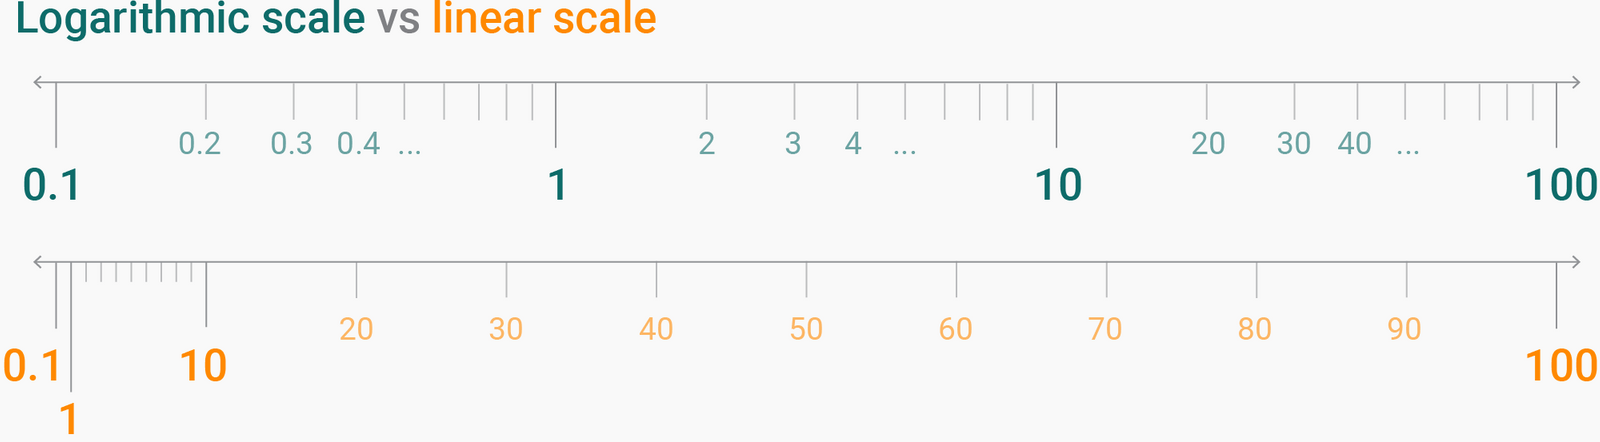

In [2]:
#we can see HV1 is skewed, with a long tail, so we could rescale this feature using the logarithmic method 

from IPython.display import Image
Image("logvlinear.png")

#### Log transformation

In [ ]:
# Warning, some values might become -inf, so we will have to filter those values out and then replace. 
#If there are too many such values this method cannot be used. 

In [ ]:
#function to rescale with log method 
def log_transfom_clean_(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN #  we can replace NANs with mean values in the next step   
data['HV1_log'] = list(map(log_transfom_clean_, data['HV1']))

In [ ]:
data['HV1_log'] = data['HV1_log'].fillna(np.mean(data['HV1_log']))

In [ ]:
#check how the distribution looks now
sns.distplot(data['HV1_log'])
plt.show()

In [ ]:
# if satisfied with the change, replace the column 
data = data.drop(['HV1'], axis=1)
data.head()

#### Box cox transformation for making data normal

In [ ]:
# this method requires the data be positive. We will use it on 'IC1'. 
# - we can filter out negative values and replace with the mean

In [ ]:
#first, deal with the zeros
data['IC1_'] = np.where(data['IC1']<=0,0,data['IC1'])
# now calculate mean of the new column , exluding zeros in the count 
mean = np.sum(data['IC1_'])/len(data[data['IC1_']>0])
data['IC1_'] = data['IC1_'].replace(0,mean)

In [ ]:
#if satisfied drop the column 
data = data.drop(['IC1'], axis=1)

In [ ]:
#next, apply the boxcox transformation 
# go to terminal and on your env install using conda install -c anaconda scipy
from scipy import stats
xt, lmbda = stats.boxcox(data['IC1_'])

In [ ]:
sns.distplot(xt)
plt.show()

In [ ]:
# Repeat the same steps for column 'IC5'
data['IC5_'] = np.where(data['IC5']<=0,0,data['IC5'])
mean = np.sum(data['IC5_'])/len(data[data['IC5_']>0])
data['IC5_'] = data['IC5_'].replace(0,mean)
data = data.drop(['IC5'], axis=1)
xt2, lmbda2 = stats.boxcox(data['IC5_'])

In [ ]:
#if satisfied with the rescaling, drop the old columns 
data['IC1_transformed'] = xt
data['IC5_transformed'] = xt2
data = data.drop(['IC1_', 'IC5_'], axis=1)
data.head()

In [ ]:
#lets define our features and label again 

y = data['TARGET_D']
X = data.drop(['TARGET_D'], axis=1)

In [ ]:
model = lm.fit(X,y)
lm.score(X,y)

In [ ]:
#Now we have our second imperfect iteration or It2 

predictions  = lm.predict(X)

In [ ]:
r2_score(y, predictions)

#### So thats all about pre processing the numerical data - before going to It3, lets switch to a dataset which contains both categorical and numerical features 

For It3 we are going to run through the steps in a more efficient way, that more closely resembles a standard ML end to end process. 


In [ ]:
#step 1 bring in the data 
data = pd.read_csv('regression_data.csv')
data.head()

In [ ]:
#step 2 divide the data into X and y
y = data['TARGET_D']
data = data.drop(['TARGET_D'], axis=1)

In [ ]:
#step 3 split the data into numeric and categorical features for pre processing
X_num = data.select_dtypes(include = np.number)
X_cat = data.select_dtypes(include = np.object)

In [ ]:
#step 4 pre processing numericals 
# option 1 standardising all numeric features / rescaling using Normalizer 
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_num)
x_normalized = transformer.transform(X_num)
print(x_normalized.shape)


In [ ]:
#option 2 standardising all numeric features / rescaling using Standard Scaler
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_num)
x_standardized = transformer.transform(X_num)
print(x_standardized.shape)


In [ ]:
#option 3 standardising all numeric features / rescaling using MinMax scaler
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(X_num)
x_mmscaled = transformer.transform(X_num)
print(x_mmscaled.shape)


https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [ ]:
#step 5 pre processing categoricals 
X_cat = data.select_dtypes(include = np.object)
X_cat


In [ ]:
#option 1 using OHE 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()
encoded


In [ ]:
#option 1 using LE
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(X_cat)
le.transform(X_cat) 
# ordered re value counts

In [ ]:
#step 6 bring the X data back together 
X = np.concatenate((x_normalized, encoded), axis=1)
# we did this already : y = data['TARGET_D']


In [ ]:
X_cat.shape
#check the shape of the array

In [ ]:
y.shape
#check the shape of the array - both X and y should have the same no of rows 

In [ ]:
#step 7 split the data into train and test randomly, as a %
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)

In [ ]:
#step 8 apply the machine learn model for It3 
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
predictions  = lm.predict(X_test)
r2_score(y_test, predictions)

#### Additional Evaluation Metrics for LR

In [ ]:
mse = mean_squared_error(y_test, predictions)
print(mse)

In [ ]:
import math 
rmse = math.sqrt(mse)
print(rmse)

In [ ]:
r2 = r2_score(y_test, predictions)
r2

In [ ]:
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
adj_r2